## Paso 1 — Carga y comprobaciones

In [3]:
# Cargamos cables.csv y eliminamos datos incorrectos e inecesarios
import pandas as pd
cables = pd.read_csv('cables.csv')
cables = cables.drop(columns=['Unnamed: 0'])
cables = cables.dropna()
cables = cables.drop_duplicates()

cables

,N,R,S,T,U,G,L
0,16.0,333.33,256.0,111.0,2198.0,786.0,686
1,36.0,776.67,1296.0,603.0,7491.0,914.0,2087
2,38.0,258.33,1444.0,66.0,1957.0,3234.0,734
3,76.0,863.33,5776.0,745.0,974.0,2377.0,3411
5,8.0,290.00,64.0,84.0,2731.0,587.0,358
...,...,...,...,...,...,...,...
485,29.0,1200.00,841.0,1440.0,2850.0,-413.0,3985
486,36.0,915.00,1296.0,837.0,3788.0,2457.0,1571
487,29.0,373.33,841.0,139.0,2485.0,2561.0,1682
488,40.0,450.00,1600.0,202.0,5059.0,2307.0,1663


## Paso 2 — Análisis exploratorio gráfico

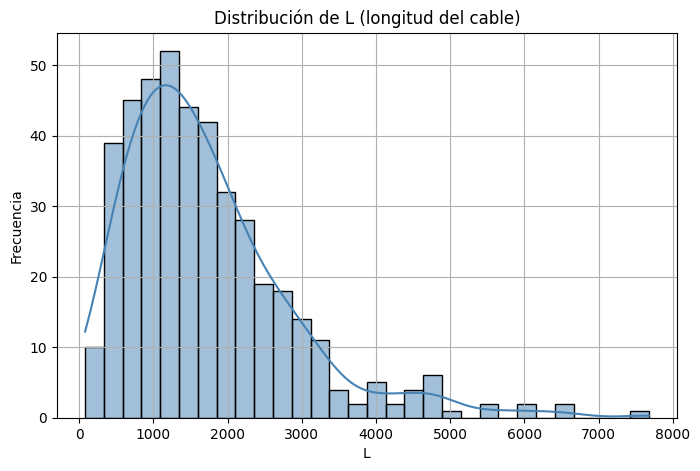

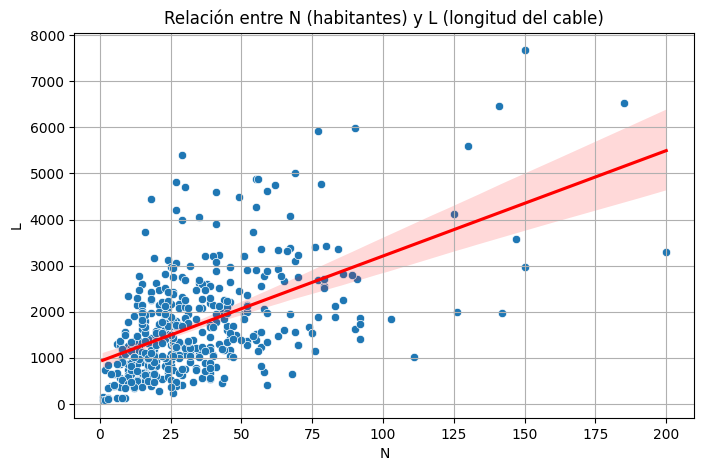

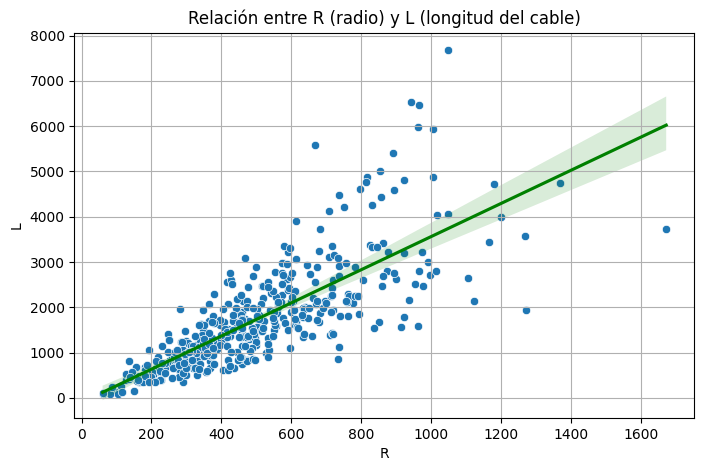

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 5))
sns.histplot(cables['L'], kde=True, bins=30, color='steelblue')
plt.title('Distribución de L (longitud del cable)')
plt.xlabel('L')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# L vs N
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables, x='N', y='L')
sns.regplot(data=cables, x='N', y='L', scatter=False, color='red')
plt.title('Relación entre N (habitantes) y L (longitud del cable)')
plt.grid(True)
plt.show()

# L vs R
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables, x='R', y='L')
sns.regplot(data=cables, x='R', y='L', scatter=False, color='green')
plt.title('Relación entre R (radio) y L (longitud del cable)')
plt.grid(True)
plt.show()

Media de N: 34.62


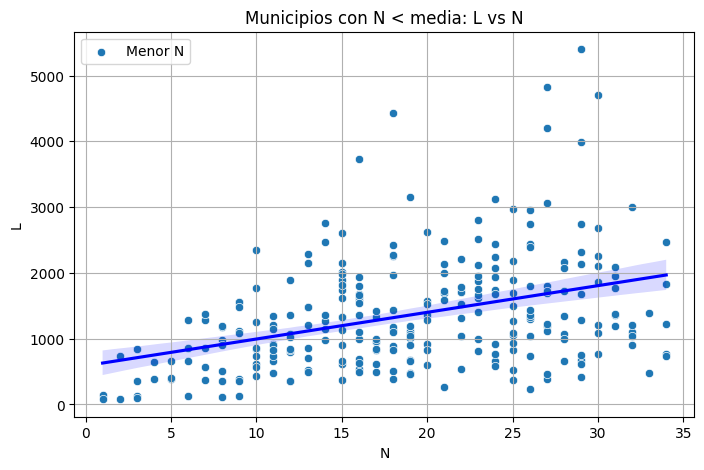

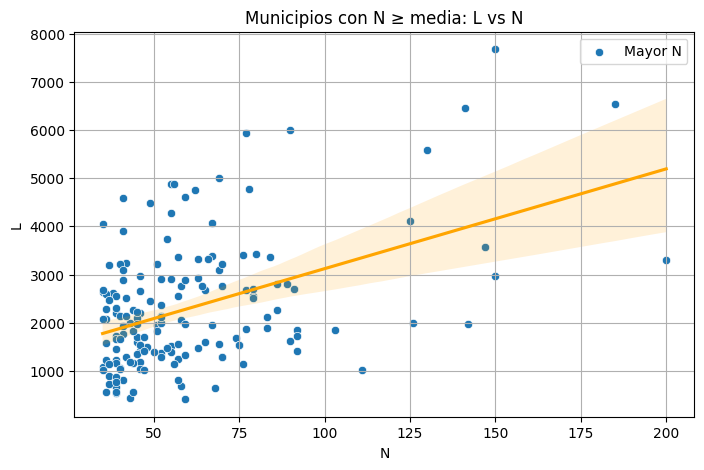

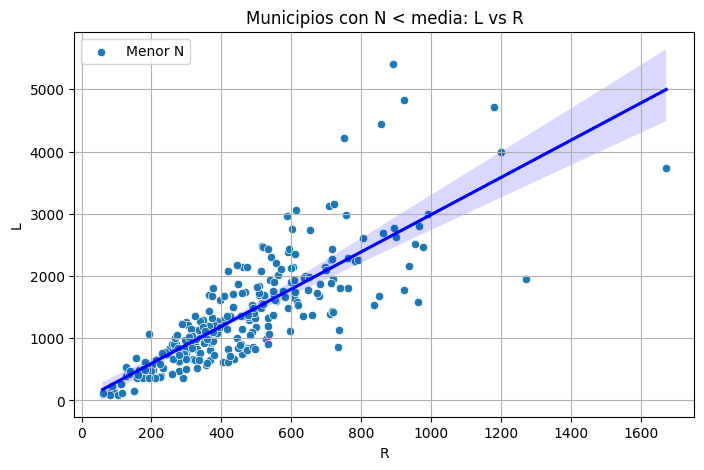

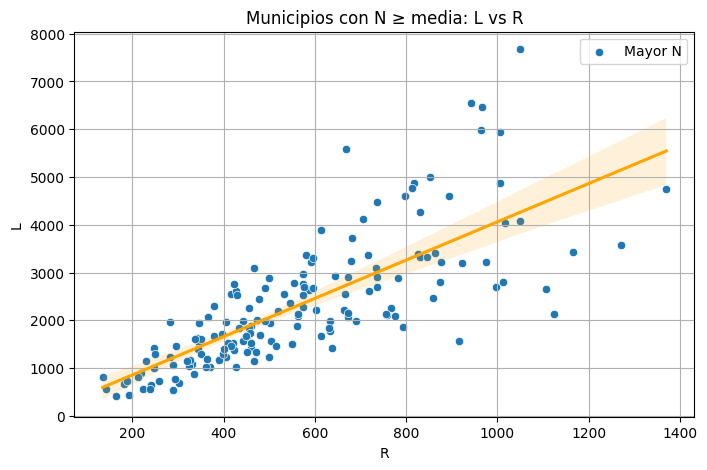

In [5]:
media_N = cables['N'].mean()
print(f"Media de N: {media_N:.2f}")

# Segmentos
cables_menores = cables[cables['N'] < media_N]
cables_mayores = cables[cables['N'] >= media_N]

# Plot: L vs N para municipios < media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_menores, x='N', y='L', label='Menor N')
sns.regplot(data=cables_menores, x='N', y='L', scatter=False, color='blue')
plt.title('Municipios con N < media: L vs N')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios >= media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_mayores, x='N', y='L', label='Mayor N')
sns.regplot(data=cables_mayores, x='N', y='L', scatter=False, color='orange')
plt.title('Municipios con N ≥ media: L vs N')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios < media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_menores, x='R', y='L', label='Menor N')
sns.regplot(data=cables_menores, x='R', y='L', scatter=False, color='blue')
plt.title('Municipios con N < media: L vs R')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios >= media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_mayores, x='R', y='L', label='Mayor N')
sns.regplot(data=cables_mayores, x='R', y='L', scatter=False, color='orange')
plt.title('Municipios con N ≥ media: L vs R')
plt.grid(True)
plt.show()

Podemos observar que la tendencia es similar en ambos grupos de datos. 

In [6]:
# Outliers en L usando el método IQR
Q1 = cables['L'].quantile(0.25)
Q3 = cables['L'].quantile(0.75)
IQR = Q3 - Q1

outliers_L = cables[(cables['L'] < Q1 - 1.5 * IQR) | (cables['L'] > Q3 + 1.5 * IQR)]
print(f"Número de outliers en L: {outliers_L.shape[0]}")


Número de outliers en L: 21


## Paso 3 — Tratamiento de valores perdidos (imputación)

In [18]:
import time
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

X = cables.drop(columns='L')
y = cables['L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

res_imput = []

imp = SimpleImputer(strategy="median")
Xtr_imp = imp.fit_transform(X_train)
Xte_imp = imp.transform(X_test)

clf = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_simple = cross_val_score(clf, Xtr_imp, y_train, cv=kf, scoring='neg_mean_squared_error')
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append(
    [
        "Imputación: mediana",
        Xtr_imp.shape[0],
        Xte_imp.shape[0],
        float(-np.mean(scores_simple)),
        r2_score(y_test, yp),
        t,
    ]
)

imp = KNNImputer(n_neighbors=5)
Xtr_imp = imp.fit_transform(X_train)
Xte_imp = imp.transform(X_test)
clf = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_simple = cross_val_score(clf, Xtr_imp, y_train, cv=kf, scoring='neg_mean_squared_error')
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append(
    [
        "Imputación: KNN (k=5)",
        Xtr_imp.shape[0],
        Xte_imp.shape[0],
        float(-np.mean(scores_simple)),
        r2_score(y_test, yp),
        t,
    ]
)

for fila in res_imput:
    print (fila)


['Imputación: mediana', 324, 109, 420029.87196691876, 0.7571416599449154, 0.001638400019146502]
['Imputación: KNN (k=5)', 324, 109, 420029.87196691876, 0.7571416599449154, 0.0007949999999254942]


## Paso 4 — Escalado/normalización (si hace falta)

In [16]:
from sklearn.preprocessing import StandardScaler

res_imput = []

# Imputación con mediana + escalado
scaler = StandardScaler()

Xtr_imp = scaler.fit_transform(Xtr_imp)

Xte_imp = scaler.transform(Xte_imp)

clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append([
    "Imputación: mediana + escalado",
    Xtr_imp.shape[0],
    Xte_imp.shape[0],
    mean_squared_error(y_test, yp),
    r2_score(y_test, yp),
    t,
])

# Imputación KNN + escalado
scaler = StandardScaler()

Xtr_imp = scaler.fit_transform(Xtr_imp)

Xte_imp = scaler.transform(Xte_imp)

clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append([
    "Imputación: KNN (k=5) + escalado",
    Xtr_imp.shape[0],
    Xte_imp.shape[0],
    mean_squared_error(y_test, yp),
    r2_score(y_test, yp),
    t,
])

for fila in res_imput:
    print(fila)

['Imputación: mediana + escalado', 324, 109, 268047.177499631, 0.7571416599449153, 0.0010158999939449131]
['Imputación: KNN (k=5) + escalado', 324, 109, 268047.177499631, 0.7571416599449153, 0.0008023999980650842]


## Paso 5 — Variables irrelevantes y outliers

In [20]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

errors = np.abs(y_test - y_pred)

df_errors = X_test.copy()
df_errors["y_real"] = y_test
df_errors["y_pred"] = y_pred
df_errors["error_abs"] = errors

df_sorted = df_errors.sort_values(by="error_abs", ascending=False)
print(df_sorted.head(10))
top_outliers = df_sorted.head(5).index

X_test_clean = X_test.drop(index=top_outliers)
y_test_clean = y_test.drop(index=top_outliers)

y_pred_clean = model.predict(X_test_clean)

print("R2 sin outliers:", r2_score(y_test_clean, y_pred_clean))
print("MSE sin outliers:", mean_squared_error(y_test_clean, y_pred_clean))

        N        R       S       T       U       G  y_real       y_pred  \
315  90.0   963.33  8100.0   928.0  1123.0  2303.0    5990  3852.207392   
322  49.0   736.67  2401.0   542.0  3061.0  1787.0    4486  2717.212136   
486  36.0   915.00  1296.0   837.0  3788.0  2457.0    1571  3062.522036   
215  23.0   850.00   529.0   722.0  6480.0  2443.0    1670  2795.660673   
470  22.0   923.33   484.0   852.0  3985.0  1520.0    1780  2866.966815   
463  47.0   636.67  2209.0   405.0  5836.0  1232.0    1409  2461.874687   
85   54.0   681.67  2916.0   464.0  7352.0  2390.0    3731  2780.010408   
82   38.0   426.67  1444.0   182.0  6952.0  1904.0    2608  1685.682108   
382  35.0  1016.67  1225.0  1033.0   832.0  -264.0    4046  3128.679112   
278  57.0   580.00  3249.0   336.0  5274.0  3322.0    3357  2459.589252   

       error_abs  
315  2137.792608  
322  1768.787864  
486  1491.522036  
215  1125.660673  
470  1086.966815  
463  1052.874687  
85    950.989592  
82    922.317892  
382

## Paso 6 — Dos modelos

In [21]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'R2': make_scorer(r2_score),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False) 
}

elastic_net = ElasticNet(max_iter=10000)

param_grid_en = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

grid_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid_en,
    scoring=scoring,
    refit='R2',  
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_en.fit(Xtr_imp, y_train)

print("Elastic Net - Mejores parámetros:", grid_en.best_params_)
print("Elastic Net - Mejor R2 (CV):", grid_en.cv_results_['mean_test_R2'][grid_en.best_index_])
print("Elastic Net - MSE (CV):", -grid_en.cv_results_['mean_test_MSE'][grid_en.best_index_])

rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring=scoring,
    refit='R2',
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(Xtr_imp, y_train)

print("Random Forest - Mejores parámetros:", grid_rf.best_params_)
print("Random Forest - Mejor R2 (CV):", grid_rf.cv_results_['mean_test_R2'][grid_rf.best_index_])
print("Random Forest - MSE (CV):", -grid_rf.cv_results_['mean_test_MSE'][grid_rf.best_index_])

print("\nComparación final:")
print(f"Elastic Net mejor R2 CV: {grid_en.best_score_:.4f}")
print(f"Random Forest mejor R2 CV: {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Elastic Net - Mejores parámetros: {'alpha': 1, 'l1_ratio': 0.1}
Elastic Net - Mejor R2 (CV): 0.6933548321400304
Elastic Net - MSE (CV): 419925.74848967313
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest - Mejores parámetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - Mejor R2 (CV): 0.6729246211681675
Random Forest - MSE (CV): 435683.2524216013

Comparación final:
Elastic Net mejor R2 CV: 0.6934
Random Forest mejor R2 CV: 0.6729
